# House Connection Forecast RNN vs LSTM
These experiments compares Simple-RNN and LSTM models for the application of prediction the power consumption cycle of an office building complex (PxC). The experiments fall in two cathegories:
- A. Many-to-one configurations use a time series sequnce in order to just predict the vone value for the next time step.
- B. Mant-to-many setups on the other hand predict a full seqeunce following the input time series.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.layers import Dense, Dropout, RepeatVector, TimeDistributed, SimpleRNN, LSTM, Activation
from keras.models import Sequential

#### Data Paths
All data paths are collected here for easy adjustments.

In [2]:
input_data_path = r"data/HouseConnection_PxC_2018_2019.csv"

## Load and Prepare Data   

In [3]:
df = pd.read_csv(input_data_path, index_col='ts', parse_dates=['ts'])
df.head()

,kw
ts,
2017-12-31 23:00:00+00:00,NaN
2017-12-31 23:15:00+00:00,21.0
2017-12-31 23:30:00+00:00,20.0
2017-12-31 23:45:00+00:00,21.0
2018-01-01 00:00:00+00:00,21.0


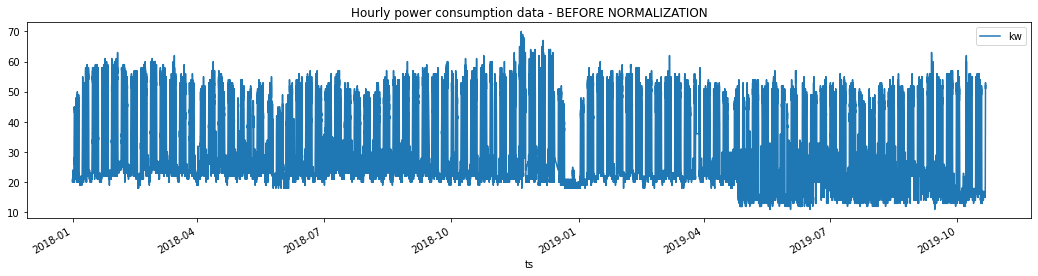

In [4]:
df.plot(figsize=(18, 4),legend=True)
plt.title('Hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [5]:
# Check missing values and drop if data loss is acceptable.
print(df.isna().sum())
df = df.dropna()

kw    1
dtype: int64


For this experiment we focus purely on the consumed kw sequence. That means we forecast future kw consumption based on a historic sequence. Therefore we do not need the weather data which was used in the random forest regressor experiment. We also need to normalize the values as this is usually better for neural networks.

In [6]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['kw'] = scaler.fit_transform(df['kw'].values.reshape(-1, 1))
    return df

In [7]:
# Normalize the data i.e. bring the values in range [-1, 1].
df_norm = normalize_data(df)
df_norm.head()

/Users/matthiastitze/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,kw
ts,
2017-12-31 23:15:00+00:00,0.169492
2017-12-31 23:30:00+00:00,0.152542
2017-12-31 23:45:00+00:00,0.169492
2018-01-01 00:00:00+00:00,0.169492
2018-01-01 00:15:00+00:00,0.152542


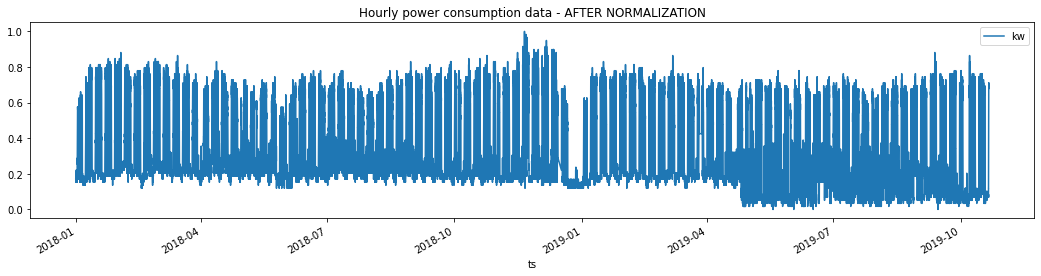

In [8]:
df_norm.plot(figsize=(18, 4),legend=True)
plt.title('Hourly power consumption data - AFTER NORMALIZATION')
plt.show()

## Extract Sequential Data for Training the RNN models.

In [9]:
df_norm.shape

(63200, 1)

In [12]:
def load_data(stock, input_seq_len, output_seq_len, num_train_samples):
    # Lists to store the extracted seqeunces for input and label.
    X = []
    y = []
    # Total length of the sequence with input followed by label data.
    total_seq_len = input_seq_len + output_seq_len
    # Iterate through the time seires data.
    # Extract sequences an split these into input and label data.
    for i in range(total_seq_len, len(stock)):
        X.append(stock.iloc[i - total_seq_len : i - output_seq_len, 0])
        y.append(stock.iloc[i - output_seq_len : i, 0])
        
    # We cut of a chunk of data at the start to use for training.
    X_train = X[:num_train_samples]           
    y_train = y[:num_train_samples]
    
    # The rest of the data can be used for testing.
    X_test = X[num_train_samples:]             
    y_test = y[num_train_samples:]
    
    # Convert the dataframes to numpy array.
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # Reshape the data to input into RNN models.
    # Note: shape[0] holds the number of sample sequences.
    X_train = np.reshape(X_train, (X_train.shape[0], input_seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], input_seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

#### Load Many-to-One Data Sequences

In [13]:
# Iterate through the time series and extract sequences.
# Use the last timestamp of each sequence as the label to predict.
X_train_mto, y_train_mto, X_test_mto, y_test_mto = load_data(df_norm,
                                                             input_seq_len=20,
                                                             output_seq_len=1,
                                                             num_train_samples=50000)
print('X_train.shape = ',X_train_mto.shape)
print('y_train.shape = ', y_train_mto.shape)
print('X_test.shape = ', X_test_mto.shape)
print('y_test.shape = ',y_test_mto.shape)

X_train.shape =  (50000, 20, 1)
y_train.shape =  (50000, 1)
X_test.shape =  (13179, 20, 1)
y_test.shape =  (13179, 1)


#### Load Many-to-Many Data Sequences

In [14]:
# Sample down the data to hourly resolution in order to reduce parameters.
# Many-to-many configurations tend to produce much more prameters otherwise.
df_norm_h = df_norm.resample('H').mean()
df_norm_h = df_norm_h.reset_index()
df_norm_h = df_norm_h.set_index('ts', drop=True)
df_norm_h.head()

,kw
ts,
2017-12-31 23:00:00+00:00,0.163842
2018-01-01 00:00:00+00:00,0.161017
2018-01-01 01:00:00+00:00,0.165254
2018-01-01 02:00:00+00:00,0.161017
2018-01-01 03:00:00+00:00,0.161017


In [15]:
# Iterate through the time series and extract sequences.
# Split each sequence into a an input and a label part (equal length).
X_train_mtm, y_train_mtm, X_test_mtm, y_test_mtm = load_data(df_norm_h,
                                                             input_seq_len=320,
                                                             output_seq_len=320,
                                                             num_train_samples=12000)
print('X_train.shape = ',X_train_mtm.shape)
print('y_train.shape = ', y_train_mtm.shape)
print('X_test.shape = ', X_test_mtm.shape)
print('y_test.shape = ',y_test_mtm.shape)

X_train.shape =  (12000, 320, 1)
y_train.shape =  (12000, 320)
X_test.shape =  (3162, 320, 1)
y_test.shape =  (3162, 320)


## Many-to-One Experiment

### Train and Predict using RNN Model Many-to-One

In [16]:
rnn_model_mto = Sequential()
rnn_model_mto.add(SimpleRNN(40, activation='tanh', return_sequences=True, input_shape=(X_train_mto.shape[1], 1)))
rnn_model_mto.add(Dropout(0.15))
rnn_model_mto.add(SimpleRNN(40, activation='tanh', return_sequences=True))
rnn_model_mto.add(Dropout(0.15))
rnn_model_mto.add(SimpleRNN(40, activation='tanh', return_sequences=False))
rnn_model_mto.add(Dropout(0.15))
rnn_model_mto.add(Dense(1))
rnn_model_mto.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [17]:
rnn_model_mto.compile(optimizer='adam', loss='MSE')
rnn_model_mto.fit(X_train_mto, y_train_mto, epochs=10, batch_size=1000)

Epoch 1/10
50/50 [==============================] - 6s 126ms/step - loss: 0.1351
Epoch 2/10
50/50 [==============================] - 5s 98ms/step - loss: 0.0413
Epoch 3/10
50/50 [==============================] - 5s 104ms/step - loss: 0.0227
Epoch 4/10
50/50 [==============================] - 5s 106ms/step - loss: 0.0164
Epoch 5/10
50/50 [==============================] - 5s 103ms/step - loss: 0.0128
Epoch 6/10
50/50 [==============================] - 7s 135ms/step - loss: 0.0106
Epoch 7/10
50/50 [==============================] - 6s 120ms/step - loss: 0.0089
Epoch 8/10
50/50 [==============================] - 9s 185ms/step - loss: 0.0079
Epoch 9/10
50/50 [==============================] - 6s 117ms/step - loss: 0.0070
Epoch 10/10
50/50 [==============================] - 6s 128ms/step - loss: 0.0063


In [18]:
rnn_predictions_mto = rnn_model_mto.predict(X_test_mto)
rnn_score_mto = r2_score(y_test_mto, rnn_predictions_mto)
print('R2 Score of RNN model = ',rnn_score_mto)

R2 Score of RNN model =  0.9529839335500799


In [19]:
rnn_predictions_mto = rnn_predictions_mto.reshape(rnn_predictions_mto.shape[0])
rnn_predictions_mto

array([0.10093056, 0.09854125, 0.09734742, ..., 0.73968494, 0.7315534 ,
       0.72397816], dtype=float32)

### Train and Predict using LSTM Model Many-to-One

In [85]:
lstm_model_mto = Sequential()
lstm_model_mto.add(LSTM(40, activation='tanh', return_sequences=True, input_shape=(X_train_mto.shape[1], 1)))
lstm_model_mto.add(Dropout(0.15))
lstm_model_mto.add(LSTM(40, activation='tanh', return_sequences=True))
lstm_model_mto.add(Dropout(0.15))
lstm_model_mto.add(LSTM(40, activation='tanh', return_sequences=False))
lstm_model_mto.add(Dropout(0.15))
lstm_model_mto.add(Dense(1))
lstm_model_mto.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [86]:
lstm_model_mto.compile(optimizer='adam', loss='MSE')
lstm_model_mto.fit(X_train_mto, y_train_mto, epochs=10, batch_size=1000)

Epoch 1/10
50/50 [==============================] - 8s 153ms/step - loss: 0.0373
Epoch 2/10
50/50 [==============================] - 8s 157ms/step - loss: 0.0137
Epoch 3/10
50/50 [==============================] - 8s 166ms/step - loss: 0.0079
Epoch 4/10
50/50 [==============================] - 9s 174ms/step - loss: 0.0068
Epoch 5/10
50/50 [==============================] - 9s 179ms/step - loss: 0.0060
Epoch 6/10
50/50 [==============================] - 10s 198ms/step - loss: 0.0054
Epoch 7/10
50/50 [==============================] - 10s 198ms/step - loss: 0.0049
Epoch 8/10
50/50 [==============================] - 9s 177ms/step - loss: 0.0045
Epoch 9/10
50/50 [==============================] - 8s 159ms/step - loss: 0.0042
Epoch 10/10
50/50 [==============================] - 8s 157ms/step - loss: 0.0039


In [91]:
lstm_predictions_mto = lstm_model_mto.predict(X_test_mto)
lstm_score_mto = r2_score(y_test_mto, lstm_predictions_mto)
print('R^2 Score of LSTM model = ',lstm_score_mto)

R^2 Score of LSTM model =  0.9275581479110977


In [92]:
lstm_predictions_mto = lstm_predictions_mto.reshape(lstm_predictions_mto.shape[0])
lstm_predictions_mto

array([0.13003048, 0.12855999, 0.12696138, ..., 0.6996431 , 0.6973502 ,
       0.69242877], dtype=float32)

### Evaluate and compare RNN and LSTM Many-to-One

In [20]:
def plot_predictions(test, predicted, title, start, end):
    plt.figure(figsize=(18, 4))
    plt.plot(test[start:end], color='blue', label='Actual power consumption data')
    plt.plot(predicted[start:end], alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

In [21]:
# Plot interval.
start = 1200
end = 1600

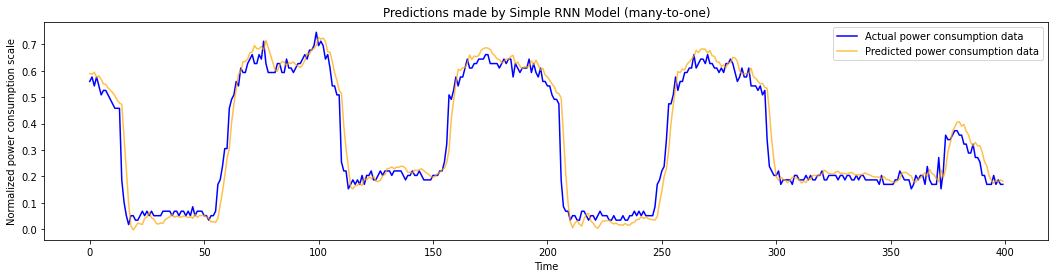

In [22]:
plot_predictions(y_test_mto, rnn_predictions_mto, 'Predictions made by Simple RNN Model (many-to-one)', start, end)

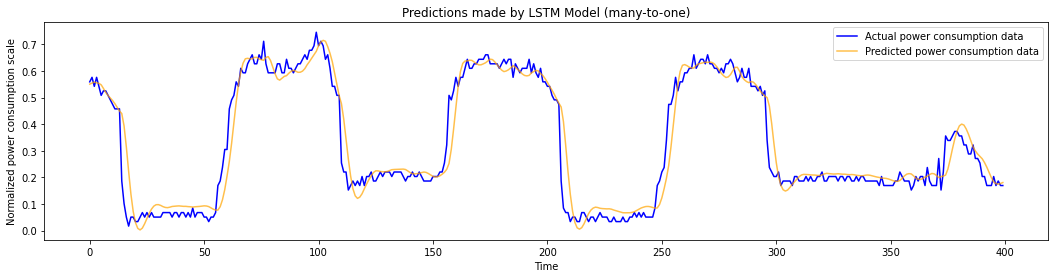

In [93]:
plot_predictions(y_test_mto, lstm_predictions_mto, 'Predictions made by LSTM Model (many-to-one)', start, end)

## Many-to-Many Experiment

### Train and Predict using RNN Model Many-to-Many

In [112]:
rnn_model_mtm = Sequential()  
rnn_model_mtm.add(SimpleRNN(320, input_shape=(X_train_mtm.shape[1], 1), return_sequences=True))  
rnn_model_mtm.add(TimeDistributed(Dense(1)))
rnn_model_mtm.add(Activation('linear'))   
rnn_model_mtm.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, 320, 320)          103040    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 320, 1)            321       
_________________________________________________________________
activation_7 (Activation)    (None, 320, 1)            0         
Total params: 103,361
Trainable params: 103,361
Non-trainable params: 0
_________________________________________________________________


In [113]:
rnn_model_mtm.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
rnn_model_mtm.fit(X_train_mtm, y_train_mtm, epochs=10, batch_size=1000)

Epoch 1/10
12/12 [==============================] - 25s 2s/step - loss: 0.7520 - accuracy: 0.0000e+00
Epoch 2/10
12/12 [==============================] - 27s 2s/step - loss: 0.0288 - accuracy: 0.0000e+00
Epoch 3/10
12/12 [==============================] - 28s 2s/step - loss: 0.0283 - accuracy: 0.0000e+00
Epoch 4/10
12/12 [==============================] - 29s 2s/step - loss: 0.1349 - accuracy: 0.0000e+00
Epoch 5/10
12/12 [==============================] - 32s 3s/step - loss: 0.1771 - accuracy: 0.0000e+00
Epoch 6/10
12/12 [==============================] - 32s 3s/step - loss: 0.0492 - accuracy: 0.0000e+00
Epoch 7/10
12/12 [==============================] - 34s 3s/step - loss: 0.0245 - accuracy: 0.0000e+00
Epoch 8/10
12/12 [==============================] - 32s 3s/step - loss: 0.0583 - accuracy: 0.0000e+00
Epoch 9/10
12/12 [==============================] - 32s 3s/step - loss: 0.2183 - accuracy: 0.0000e+00
Epoch 10/10
12/12 [==============================] - 36s 3s/step - loss: 0.0468 - 

In [114]:
rnn_predictions_mtm = rnn_model_mtm.predict(X_test_mtm)
rnn_predictions_mtm = rnn_predictions_mtm.reshape((rnn_predictions_mtm.shape[0], rnn_predictions_mtm.shape[1]))
rnn_predictions_mtm.shape

(3162, 320)

In [23]:
rnn_model_mtm_2 = Sequential()  
rnn_model_mtm_2.add(SimpleRNN(20, input_shape=(X_train_mtm.shape[1], 1), return_sequences=True))  
rnn_model_mtm_2.add(TimeDistributed(Dense(1)))
rnn_model_mtm_2.add(Activation('linear'))   
rnn_model_mtm_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 320, 20)           440       
_________________________________________________________________
time_distributed (TimeDistri (None, 320, 1)            21        
_________________________________________________________________
activation (Activation)      (None, 320, 1)            0         
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [24]:
rnn_model_mtm_2.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
rnn_model_mtm_2.fit(X_train_mtm, y_train_mtm, epochs=10, batch_size=1000)

Epoch 1/10
12/12 [==============================] - 3s 246ms/step - loss: 0.2472 - accuracy: 0.0000e+00
Epoch 2/10
12/12 [==============================] - 3s 290ms/step - loss: 0.0702 - accuracy: 0.0000e+00
Epoch 3/10
12/12 [==============================] - 2s 195ms/step - loss: 0.0355 - accuracy: 0.0000e+00
Epoch 4/10
12/12 [==============================] - 2s 192ms/step - loss: 0.0286 - accuracy: 0.0000e+00
Epoch 5/10
12/12 [==============================] - 2s 195ms/step - loss: 0.0255 - accuracy: 0.0000e+00
Epoch 6/10
12/12 [==============================] - 3s 264ms/step - loss: 0.0215 - accuracy: 0.0000e+00
Epoch 7/10
12/12 [==============================] - 3s 243ms/step - loss: 0.0184 - accuracy: 0.0000e+00
Epoch 8/10
12/12 [==============================] - 3s 291ms/step - loss: 0.0169 - accuracy: 0.0000e+00
Epoch 9/10
12/12 [==============================] - 3s 221ms/step - loss: 0.0163 - accuracy: 0.0000e+00
Epoch 10/10
12/12 [==============================] - 3s 221ms/st

In [25]:
rnn_predictions_mtm_2 = rnn_model_mtm_2.predict(X_test_mtm)
rnn_predictions_mtm_2 = rnn_predictions_mtm_2.reshape((rnn_predictions_mtm_2.shape[0], rnn_predictions_mtm_2.shape[1]))
rnn_predictions_mtm_2.shape

(3162, 320)

### Train and Predict using LSTM Model Many-to-Many

In [34]:
lstm_model_mtm = Sequential()  
lstm_model_mtm.add(LSTM(320, input_dim=1, return_sequences=True))  
lstm_model_mtm.add(TimeDistributed(Dense(1)))
lstm_model_mtm.add(Activation('linear'))   
lstm_model_mtm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 320)         412160    
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1)           321       
_________________________________________________________________
activation_2 (Activation)    (None, None, 1)           0         
Total params: 412,481
Trainable params: 412,481
Non-trainable params: 0
_________________________________________________________________


In [35]:
lstm_model_mtm.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
lstm_model_mtm.fit(X_train_mtm, y_train_mtm, epochs=5, batch_size=1000)

Epoch 1/5
12/12 [==============================] - 101s 8s/step - loss: 0.0776 - accuracy: 0.0000e+00
Epoch 2/5
12/12 [==============================] - 99s 8s/step - loss: 0.0288 - accuracy: 0.0000e+00
Epoch 3/5
12/12 [==============================] - 115s 10s/step - loss: 0.0271 - accuracy: 0.0000e+00
Epoch 4/5
12/12 [==============================] - 104s 9s/step - loss: 0.0212 - accuracy: 0.0000e+00
Epoch 5/5
12/12 [==============================] - 111s 9s/step - loss: 0.0215 - accuracy: 0.0000e+00


In [36]:
lstm_predictions_mtm = lstm_model_mtm.predict(X_test_mtm)
lstm_predictions_mtm = lstm_predictions_mtm.reshape((lstm_predictions_mtm.shape[0], lstm_predictions_mtm.shape[1]))
lstm_predictions_mtm.shape

(3162, 320)

In [138]:
lstm_model_mtm_2 = Sequential()  
lstm_model_mtm_2.add(LSTM(20, input_dim=1, return_sequences=True))  
lstm_model_mtm_2.add(TimeDistributed(Dense(1)))
lstm_model_mtm_2.add(Activation('linear'))   
lstm_model_mtm_2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 1)           21        
_________________________________________________________________
activation_12 (Activation)   (None, None, 1)           0         
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [139]:
lstm_model_mtm_2.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy']) 
lstm_model_mtm_2.fit(X_train_mtm, y_train_mtm, epochs=5, batch_size=1000)

Epoch 1/5
12/12 [==============================] - 4s 368ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 2/5
12/12 [==============================] - 5s 450ms/step - loss: 0.0454 - accuracy: 0.0000e+00
Epoch 3/5
12/12 [==============================] - 5s 454ms/step - loss: 0.0370 - accuracy: 0.0000e+00
Epoch 4/5
12/12 [==============================] - 5s 381ms/step - loss: 0.0313 - accuracy: 0.0000e+00
Epoch 5/5
12/12 [==============================] - 5s 413ms/step - loss: 0.0266 - accuracy: 0.0000e+00


In [140]:
lstm_predictions_mtm_2 = lstm_model_mtm_2.predict(X_test_mtm)
lstm_predictions_mtm_2 = lstm_predictions_mtm_2.reshape((lstm_predictions_mtm_2.shape[0], lstm_predictions_mtm_2.shape[1]))
lstm_predictions_mtm_2.shape

(3162, 320)

### Evaluate and compare RNN and LSTM Many-to-Many

In [26]:
def plot_single_many_to_many_prediction(test, predicted, test_sample_to_plot, title):
    plt.figure(figsize=(18, 4))
    plt.title(title + " at timestep: " + str(test_sample_to_plot))
    plt.plot(predicted[test_sample_to_plot], color='orange', label='Predicted power consumption data')
    plt.plot(test[test_sample_to_plot], color='blue', label='Actual power consumption data')

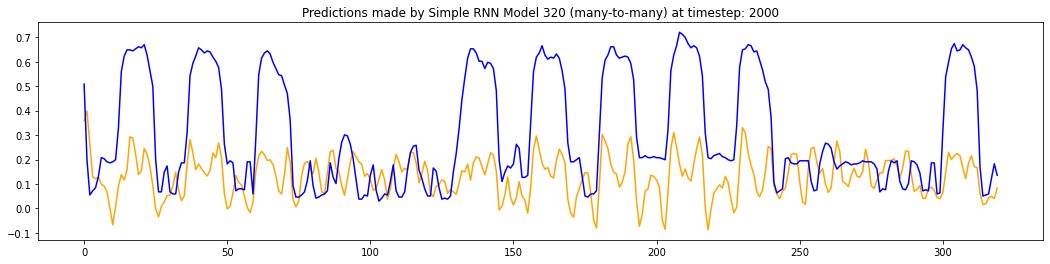

In [148]:
plot_single_many_to_many_prediction(y_test_mtm, rnn_predictions_mtm, 2000,
                                   "Predictions made by Simple RNN Model 320 (many-to-many)")

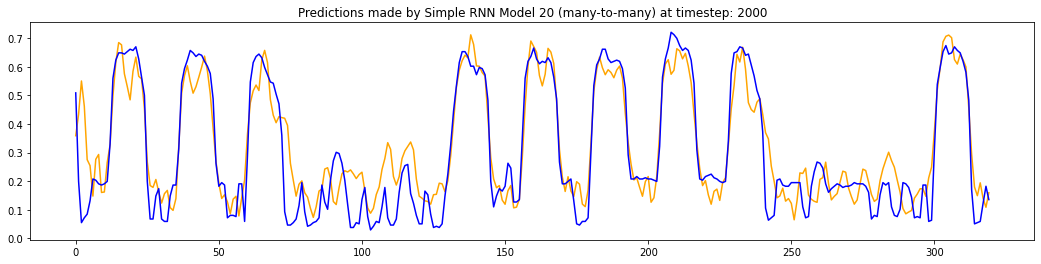

In [27]:
plot_single_many_to_many_prediction(y_test_mtm, rnn_predictions_mtm_2, 2000,
                                   "Predictions made by Simple RNN Model 20 (many-to-many)")

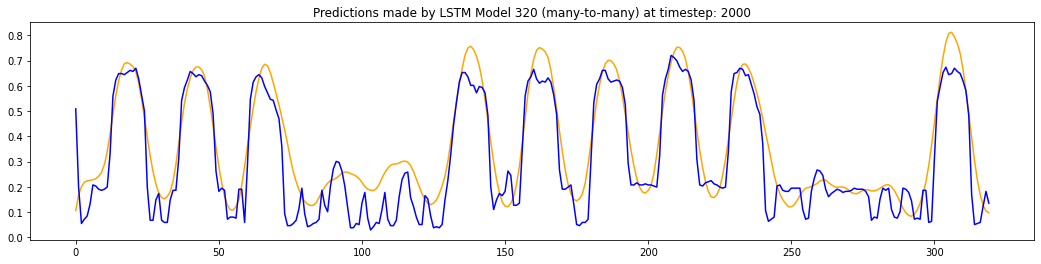

In [150]:
plot_single_many_to_many_prediction(y_test_mtm, lstm_predictions_mtm, 2000,
                                    "Predictions made by LSTM Model 320 (many-to-many)")

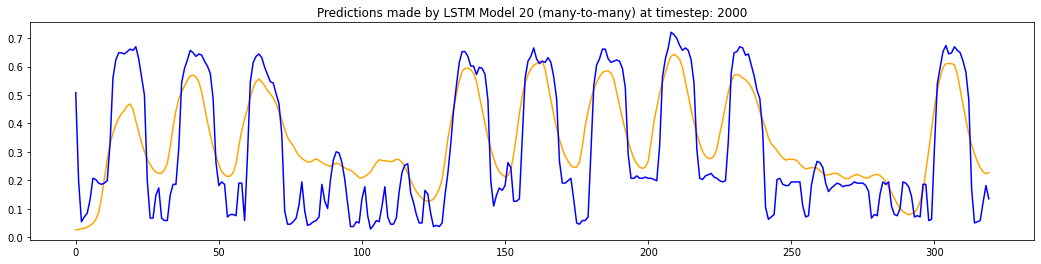

In [152]:
plot_single_many_to_many_prediction(y_test_mtm, lstm_predictions_mtm_2, 2000,
                                    "Predictions made by LSTM Model 20 (many-to-many)")

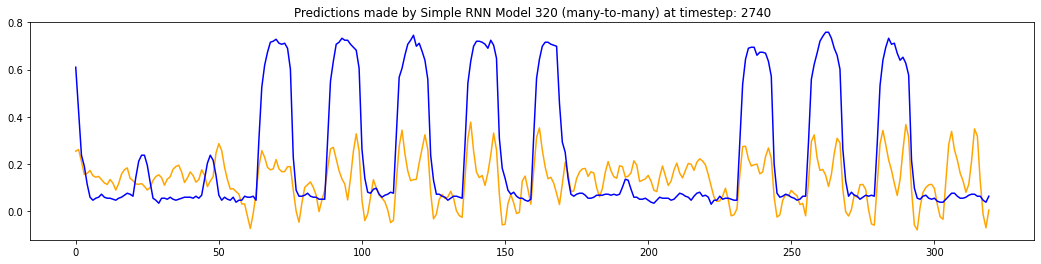

In [153]:
plot_single_many_to_many_prediction(y_test_mtm, rnn_predictions_mtm, 2740,
                                   "Predictions made by Simple RNN Model 320 (many-to-many)")

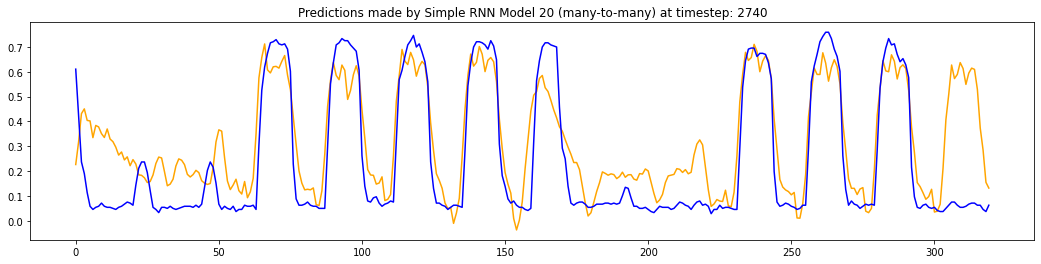

In [31]:
plot_single_many_to_many_prediction(y_test_mtm, rnn_predictions_mtm_2, 2740,
                                   "Predictions made by Simple RNN Model 20 (many-to-many)")

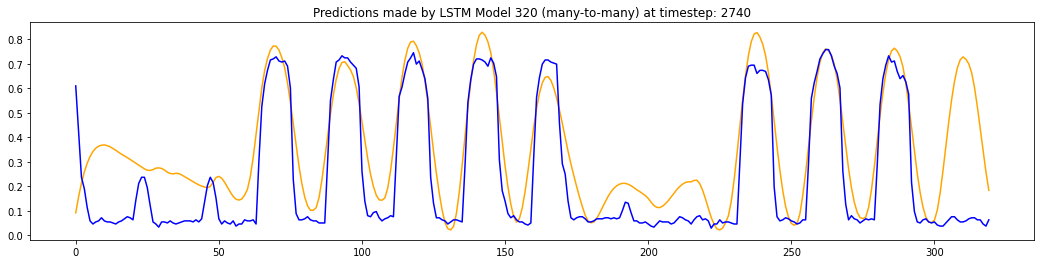

In [155]:
plot_single_many_to_many_prediction(y_test_mtm, lstm_predictions_mtm, 2740,
                                   "Predictions made by LSTM Model 320 (many-to-many)")

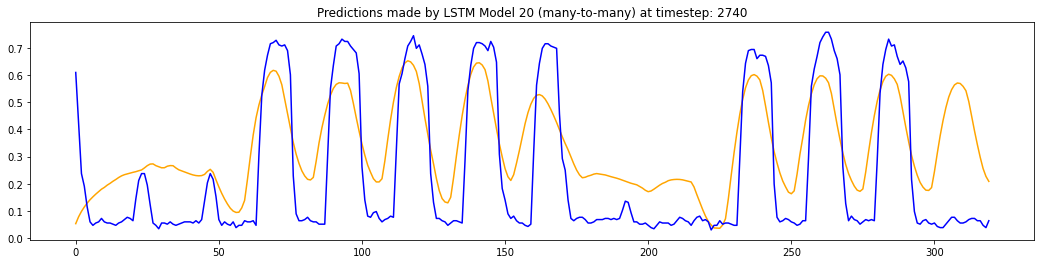

In [156]:
plot_single_many_to_many_prediction(y_test_mtm, lstm_predictions_mtm_2, 2740,
                                   "Predictions made by LSTM Model 20 (many-to-many)")